In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing
from itertools import product
from scipy import interpolate, stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib import animation
import math
from matplotlib.patches import Polygon
from random import randrange


In [2]:
# Finish google drive integration: organize it so no longer need to pull test cases and transfer them constantly
# better saving name system once merged to distnguish ?
# make a quick little code for navigating back from a directory when doing test cases
# Sort code structure and do test cases
# work on outline for paper
# Push commits for sonication station
# QD updates 

In [5]:
def load_datadf(path):
    df = pd.read_csv(path) 
    return df
def apply_column_filter(df, column_name, min=None, max=None): 
    pass

def standardize_training(data_list):
    data_reshaped = data_list[:, np.newaxis]
    scaler = preprocessing.RobustScaler().fit(data_reshaped)
    data_scaled = scaler.transform(data_reshaped)
    
    return data_scaled, scaler

def create_product_mesh(x1,x2):
    x1x2 = np.array(list(product(x1, x2)))
    x1_expanded = x1x2[:,0][:,0]
    x2_expanded = x1x2[:,1][:,0]
    return x1x2

def create_hull(x1,x2, graph = False):# inputs must be (1,n)
    hull_1 = x1[:,0]
    hull_2 = x2[:,0]
    hull_2d_points = np.asarray([hull_1, hull_2]).T
    hull = ConvexHull(hull_2d_points)
    
    if graph == True:
        for simplex in hull.simplices:
            plt.plot(hull_2d_points[simplex, 0], hull_2d_points[simplex, 1], 'k-')
    
    return hull

def point_in_hull(hull,x1,x2,graph=False):
    hull_path = Path(hull_2d_points[hull.vertices])
    if hull_path.contains_point((x1,x2)) == True:
        if graph == True:
            plt.plot(x1,x2,'o',c='r')
        return True
    else:
        return False

In [87]:
from random import randint

def lcg_params(u, v):
    # Generate parameters for an LCG that produces a maximal length sequence
    # of numbers in the range (u..v)
    diff = v - u
    if diff < 4:
         raise ValueError("Sorry, range must be at least 4.")
    m = 2 ** diff.bit_length()              # Modulus
    a = (randint(1, (m >> 2) - 1) * 4) + 1  # Random odd integer, (a-1) divisible by 4
    c = randint(3, m) | 1                   # Any odd integer will do
    return (m, a, c, u, diff + 1)

def generate_pseudorandom_sequence(rmin, rmax):
    (m, a, c, offset, seqlength) = lcg_params(rmin, rmax)
    x = 1         # Start with a seed value of 1
    result = []   # Create empty list for output values
    for i in range(seqlength):
        # To generate numbers on the fly without storing them in an array,
        # just run the following while loop to fetch a new number
        while True:
            x = (x * a + c) % m             # Iterate LCG until we get a value in the
            if x < seqlength: break         # required range
        result.append(x + offset)           # Add this value to the list
    return result

In [120]:
path1 = r"C:\Users\Edwin\Downloads\test_df"
data = load_datadf(path1)
data = data[data['400.0nm'] < 0.2] 

indexes = data.index.to_list()
random_assigned = np.random.randint(low=0, high=len(indexes)-1, size=(len(indexes),))#generate_pseudorandom_sequence(0, len(indexes)-1)
data.index = random_assigned
n = 50
random_value = np.random.randint(low=0, high=len(indexes)-1, size=(n,))
data = data.iloc[random_value]

absorbance_400 = np.asarray(pd.to_numeric(data['400.0nm'] , errors='coerce')[1:-1])
comp1 = np.asarray(pd.to_numeric(data['Component 1 wtf'] , errors='coerce')[1:-1]) # -1 removes the blank
comp2 = np.asarray(pd.to_numeric(data['Component 2 wtf'] , errors='coerce')[1:-1]) 
comp3 = np.asarray(pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[1:-1])
comp4 = np.asarray(pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[1:-1])
comp5 = np.asarray(pd.to_numeric(data['Component 5 wtf'] , errors='coerce')[1:-1])

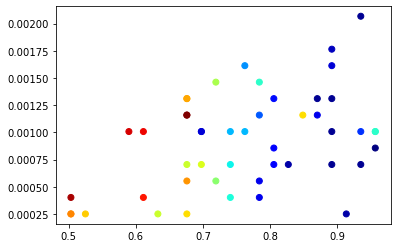

In [122]:
# load and standardize data
x1_training = comp4
x2_training = comp3
y_training = absorbance_400

x1_training_scaled, x1_scaler = standardize_training(x1_training)
x2_training_scaled, x2_scaler = standardize_training(x2_training)
y_training_scaled, y_scaler = standardize_training(y_training)
x1x2_training_scaled = np.asarray([x1_training_scaled[:,0], x2_training_scaled[:,0]]).T

# set min/max

scale = 1
x1_sct_min = min(x1_training_scaled) + min(x1_training_scaled)*scale
x1_sct_max = max(x1_training_scaled) + max(x1_training_scaled)*scale
x2_sct_min = min(x2_training_scaled) + min(x2_training_scaled)*scale
x2_sct_max = max(x2_training_scaled) + max(x2_training_scaled)*scale

plt.scatter(x1_training, x2_training, c = y_training, cmap='jet')

In [123]:
# Create the model and fit the data 
kernal = C(1, (1e-1, 1e3)) * RBF(1, (1e-3, 1e3)) 
gpmodel = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10,alpha=0.05, normalize_y=True) # random_state=42
gpmodel.fit(x1x2_training_scaled, y_training_scaled)

GaussianProcessRegressor(alpha=0.05, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [124]:
# test data is inherently scaled given the inputs, if not then would need to rescale
x1_test = np.linspace(x1_sct_min,x1_sct_max,100)
x2_test = np.linspace(x2_sct_min,x2_sct_max,100)
x1x2_test = create_product_mesh(x1_test, x2_test)

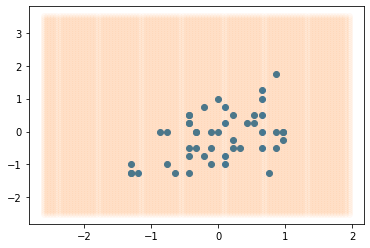

In [125]:
# verifying test arrays and resulting mesh are in range of test data
plt.scatter(x1_training_scaled, x2_training_scaled)
plt.scatter(x1x2_test[:,0][:,0], x1x2_test[:,1][:,0], alpha = 0.03)

In [126]:
# Run the test data through and convert results back from standardized to original units
x1_test_ex = x1x2_test[:,0][:,0]
x2_test_ex = x1x2_test[:,1][:,0]
x1x2_test_reform = np.asarray([x1_test_ex, x2_test_ex]).T
y_pred, MSE = gpmodel.predict(x1x2_test_reform, return_std=True) 

x1_test_org = x1_scaler.inverse_transform(x1x2_test[:,0]) 
x2_test_org = x2_scaler.inverse_transform(x1x2_test[:,1])
y_pred_org = y_scaler.inverse_transform(y_pred)

In [127]:
# Select data of interst and create meshes
x1 = x1_training
x2 = x2_training
y = y_training

dim_x1_test = x1_test.shape[0] # diff
dim_x2_test = x2_test.shape[0]

x1_mesh_prep = x1_test_org
x2_mesh_prep = x2_test_org
y_mesh_prep = y_pred_org

X1 = x1_mesh_prep.reshape(dim_x2_test, dim_x1_test)
X2 = x2_mesh_prep.reshape(dim_x2_test, dim_x1_test)
Y = np.reshape(y_mesh_prep,(dim_x2_test, dim_x1_test))
print(X1.shape, X2.shape, Y.shape, y_mesh_prep.shape)

(100, 100) (100, 100) (100, 100) (10000, 1)


In [128]:
hull_1 = x1_training
hull_2 = x2_training
hull_2d_points = np.asarray([hull_1, hull_2]).T
hull = ConvexHull(hull_2d_points)

hull_indices = hull.vertices
pts = np.asarray([x1_training[:, np.newaxis],x2_training[:, np.newaxis]]).T[0]
hull_pts = pts[hull_indices, :]
p = Polygon(hull_pts , facecolor = 'k')
# figure out a better way to cut contour plots and begin classification protocol

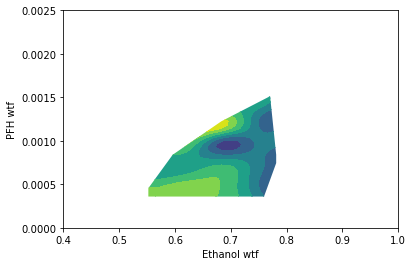

In [129]:
# The following are tied together I believe due to flipmasking

hull = create_hull(x1_training[:, np.newaxis],x2_training[:, np.newaxis], graph=False)    
hull_indices = hull.vertices
hull_pts = pts[hull_indices, :]

d = hull_pts
d = [(di*1) for di in d]
p = Polygon(d, facecolor = 'k')
ax.add_patch(p)

# Scatter plots for contour plot
fig, ax = plt.subplots(1)
ax.set_xlim(0.4,1)
ax.set_ylim(0,0.0025)
# ax.scatter(x1_training,x2_training)
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
cs = ax.contourf(X1,X2,Y)

for coll in cs.collections:
    coll.set_clip_path(p)



In [130]:
%matplotlib inline

Text(0, 0.5, 'PFH wtf')

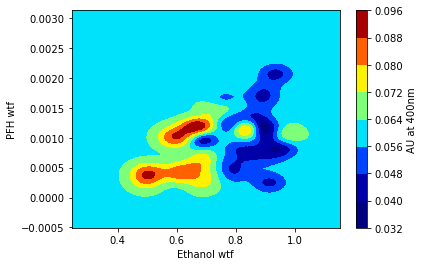

In [132]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)

norm =colors.Normalize(vmin=vmin,vmax=vmax) 
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
cbar = fig.colorbar(cs)

cbar.ax.set_ylabel('AU at 400nm')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')

# for coll in cs.collections:
#     coll.set_clip_path(p)

# odd patch behavior, it is not relative, and will not show when doing random test

In [ ]:
p.facecolor

In [ ]:
print(d)

In [ ]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
ax.set_xlim(0.4, 1)

# ax.set_ylim(0, 0.0025)




In [ ]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)



vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 
# mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')

ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
# ax.set_xlim([0.5,1])
# ax.set_ylim(0, 0.0025)
for coll in cs.collections:
    coll.set_clip_path(p)
    
    
# ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')

In [ ]:
fig, ax = plt.subplots(1)
ax.tricontour(x1, x2, levels=14, linewidths=0.5, colors='k')

In [ ]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
# ax.set_xlim(0.4, 1)
# ax.set_ylim(0, 0.0025)
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
ax.scatter(x1,x2,c=y, norm=norm,cmap='jet')



In [ ]:

# populate outline with expl. of what you are doing here: What is robust scalar, fundamentals of model and limitations. 
# Contour plot, with convex hull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

cbaxes = fig.add_axes([0.7, 0.85, 0.2, 0.03]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap='jet'), shrink=0.3, aspect=5, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('AU at 400nm', rotation=0)

ax.set_xlabel('Ethanol (wtf)')
ax.set_ylabel('Perfluorocarbon (wtf)')
ax.set_zlabel('AU at 400nm')
# ax.set_zlim(0.0,0.1)

# ax.contourf(X1,X2,Y, zdir='z',offset=0.04, cmap='jet', norm=norm)
# for coll in cs.collections:
#     coll.set_clip_path(p)

In [ ]:
xI = x1_mesh_prep[:,0].tolist()
yI = x2_mesh_prep[:,0].tolist()
zI = y_mesh_prep[:,0].tolist()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(xI,yI,zI)
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


n_radii = 8
n_angles = 36

# Make radii and angles spaces (radius r=0 omitted to eliminate duplication).
radii = np.linspace(0.125, 1.0, n_radii)
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius.
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords.
# (0, 0) is manually added at this stage,  so there will be no duplicate
# points in the (x, y) plane.
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Compute z to make the pringle surface.
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

plt.show()
x.shape

In [ ]:
y_mesh_prep.shape

In [ ]:
# plot with MSE
# populate outline with expl. of what you are doing here: What is robust scalar, fundamentals of model and limitations. 
# Contour plot, with convex hull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
surf = ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

cbaxes = fig.add_axes([0.7, 0.85, 0.2, 0.03]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap='jet'), shrink=0.3, aspect=5, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('AU at 400nm', rotation=0)

ax.set_xlabel('Ethanol (wtf)')
ax.set_ylabel('Perfluorocarbon (wtf)')
ax.set_zlabel('AU at 400nm')
# ax.set_zlim(0.0,0.1)


for coll in surf.collections:
    coll.set_clip_path(p)

In [ ]:
hull = create_hull(x1_training[:, np.newaxis],x2_training[:, np.newaxis], graph=True)    

hull_indices = hull.vertices
hull_pts = pts[hull_indices, :]


y = hull_pts

p = Polygon(y, facecolor = 'k')

fig,ax = plt.subplots()

ax.add_patch(p)
ax.set_xlim(0.4, 1)
ax.set_ylim(0, 0.0025)
plt.show()

# Scatter plots for contour plot
fig, ax = plt.subplots(1)

cs = ax.contourf(X1,X2,Y)
ax.scatter(x1_training,x2_training)
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')

ax.set_xlim(0.4, 1)
ax.set_ylim(0, 0.0025)
for coll in cs.collections:
    coll.set_clip_path(p)

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.mlab import griddata
import numpy as np
import pandas as pd

df = pd.DataFrame({'x':[0, 0, 1, 1, 3, 3, 3, 4, 4, 4], 
                   'y':[0, 1, 0, 1, 0.2, 0.7, 1.4, 0.2, 1.4, 2], 
                   'z':[50, 40, 40, 30, 30, 30, 20, 20, 20, 10]})

x = df['x']
y = df['y']
z = df['z']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
z_grid = griddata(x, y, z, xi, yi, interp='linear')

clipindex = [ [0,2,4,7,8,9,6,3,1,0],
              [0,2,4,7,5,8,9,6,3,1,0],
              [0,2,4,7,8,9,6,5,3,1,0]]

fig, axes = plt.subplots(ncols=3, sharey=True)
for i, ax in enumerate(axes):
    cont = ax.contourf(xi, yi, z_grid, 15)
    ax.scatter(x, y, color='k') # The original data points
    ax.plot(x[clipindex[i]], y[clipindex[i]], color="crimson")

    clippath = Path(np.c_[x[clipindex[i]], y[clipindex[i]]])
    patch = PathPatch(clippath, facecolor='none')
    ax.add_patch(patch)
    for c in cont.collections:
        c.set_clip_path(patch)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.patches as patches

def func(x, y):
  return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
cs = ax.contourf(grid_x,grid_y,grid_z0)

circ = patches.Circle((0.6, 0.4), 0.3, transform=ax.transData)

for coll in cs.collections:
    coll.set_clip_path(p)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


Z = np.array([
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    ])

x, y = Z.shape

xs = np.arange(x)
ys = np.arange(y)
X, Y = np.meshgrid(xs, ys)


R = np.where(X>=Y, Z, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, linewidth=0)

fig.show()
R

In [ ]:
hull = create_hull(x1_training_scaled,x2_training_scaled, graph=True)    

# x1_hull = []
# x2_hull = []
# for x1,x2 in zip(x1_test_ex, x2_test_ex):
#     if point_in_hull(hull, x1,x2) == True:
#         x1_hull.append(x1)
#         x2_hull.append(x2)
#         plt.plot(x1,x2,'o',c='r')
        
# x1_hull = np.asarray(x1_hull)
# x2_hull = np.asarray(x2_hull)

In [ ]:
x1 = x1_training[:, np.newaxis]
x2 = x2_training[:, np.newaxis]

pts = np.asarray([x1,x2]).T[0]
ch = ConvexHull(pts)
hull_indices = ch.vertices
hull_pts = pts[hull_indices, :]

plt.plot(pts[:, 0], pts[:, 1], 'ko', markersize=10)
plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'ro', alpha=.25, markersize=20)

plt.show()

print(hull_pts[0:5])
print(ch.simplices)

In [ ]:
hull_pts

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

verts = hull_pts[0:8]

codes = [
    Path.MOVETO,
    Path.LINETO, # add more to more complex
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
# ax.set_xlim(-2, 2)
ax.set_ylim(0, 0.003)
plt.show()
print(patch)

In [ ]:
verts = hull_pts[0:6]

codes = [
    Path.MOVETO,
    Path.CURVE3,
    Path.CURVE3,
    Path.CURVE3,
    Path.CURVE3,
    Path.CLOSEPOLY
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*verts)
# ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)
ax.set_ylim(0,0.0025)
ax.set_xlim(0.4,1)
plt.scatter(x1_training, x2_training)
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess

In [ ]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init():
    # Plot the surface.
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=50, blit=True)

In [ ]:
os.getcwd()
fn = 'rotate_azimuth_angle_3d_surf_slow'
ani.save(fn+'.gif',writer='imagemagick',fps=1000/50)

In [ ]:
cmd = 'magick convert %s.gif -fuzz 5%% -layers Optimize %s_r.gif'%(fn,fn)# #this saves it/stitches it together
# plt.rcParams['animation.html'] = 'html5'
# ani